In [1]:
!pip install -q pyfiglet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


  ______                      ____         
 /_  __/________ _____  _____/ __/__  _____
  / / / ___/ __ `/ __ \/ ___/ /_/ _ \/ ___/
 / / / /  / /_/ / / / (__  ) __/  __/ /    
/_/ /_/   \__,_/_/ /_/____/_/  \___/_/     
                                           
    __                          _            
   / /   ___  ____ __________  (_)___  ____ _
  / /   / _ \/ __ `/ ___/ __ \/ / __ \/ __ `/
 / /___/  __/ /_/ / /  / / / / / / / / /_/ / 
/_____/\___/\__,_/_/  /_/ /_/_/_/ /_/\__, /  
                                    /____/   



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


distilbert-base-uncased model and tokenizer loaded successfully
Classification head attached to distilbert-base-uncased model successfully
Dataset of size 10000 rows loaded successfully! 80.0% of it will be used for training.
Freezing the distilbert-base-uncased model layers
Classifier will use GPU

Optimizer loaded:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

Loss-Function loaded:
CrossEntropyLoss()

Model accuracy before training: 47.00%

Starting Training...
Epoch 1 | Training Loss: 0.8899 | Validation Loss 0.8597
Epoch 2 | Training Loss: 0.3837 | Validation Loss 0.7617
Epoch 3 | Training Loss: 0.4005 | Validation Loss 0.6625
Epoch 4 | Training Loss: 0.3698 | Validation Loss 0.6083
Epoch 5 | Training Loss: 0.3489 | Validation Loss 0.5678
Epoch 6 | Training Loss: 0.3340 | Validation Loss 0.5367
Epoch 7 | Tra

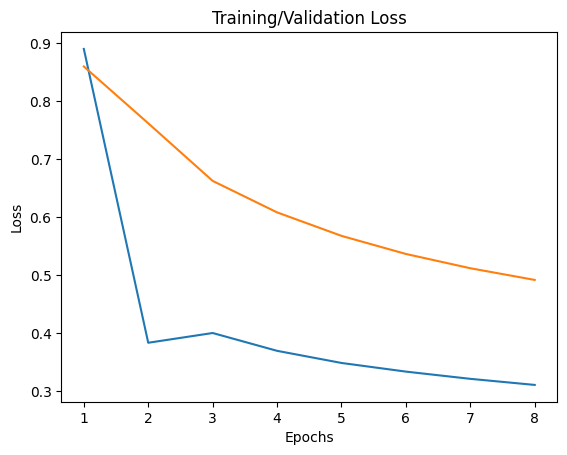

Model accuracy after training: 87.40%



In [2]:
import time
import os
import pyfiglet
from typing import List, Tuple, Dict, Any, Union
import pandas as pd
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATASET_PATH = "/content/AI_Human_Refined.csv"
NUMBER_OF_EPOCHS = 8
LEARNING_RATE = 5e-4
BATCH_SIZE = 256
MODEL_SAVE_PATH = "/content/"


class DistilbertModelHandler:
    """
    Handles all the operations related to the distilbert-base-uncased model
    (and tokenizer) being used for Real/AI text classification.
    """

    def __init__(self) -> None:
        """
        Initialises the distilbert-base-uncased model and tokenizer.
        """
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        print(f"distilbert-base-uncased model and tokenizer loaded successfully")

    def __call__(self, batch: List[str]) -> torch.Tensor:
        """
        Processes input text and runs it through the model.
        """
        tokenized_inputs = self.tokenize_batch(batch)
        outputs = self.model(**tokenized_inputs)
        return outputs.last_hidden_state

    def tokenize_batch(self, batch: Union[str, List[str]]) -> Dict[str, Any]:
        """
        Tokenizes the batch of input text.
        """
        return self.tokenizer(
            batch,
            add_special_tokens=True,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(DEVICE)


class DistilbertWithClassifier(nn.Module):
    """
    distilbert-base-uncased model with a binary-classification head. To be trained
    for classifying text as real or AI-generated.
    """

    def __init__(self, distilbert_handler: DistilbertModelHandler, num_labels=2) -> None:
        """
        Loads the distilbert-base-uncased model and adds a binary
        classification head (a linear layer).
        """
        super(DistilbertWithClassifier, self).__init__()
        self.distilbert_handler = distilbert_handler
        self.classifier = nn.Linear(in_features=self.distilbert_handler.model.config.hidden_size, out_features=num_labels, device=DEVICE)
        print("Classification head attached to distilbert-base-uncased model successfully")

    def forward(self, batch: List[str]) -> torch.Tensor:
        """Forward pass through the model for binary classification."""
        outputs = self.distilbert_handler(batch)
        cls_embedding = outputs[:, 0, :]    # ONLY TAKING CLS TOKEN
        probability = self.classifier(cls_embedding)
        return probability

    def freeze_distilbert_weights(self) -> None:
        """Freezes entire distilbert architecture."""
        print("Freezing the distilbert-base-uncased model layers")
        for param in self.distilbert_handler.model.parameters():
            param.requires_grad = False


class DatasetHandler:
    """
    Handles all the operations related to the dataset of Real/AI text classifier.
    """

    def __init__(self, csv_dataset_path: str, train_split=0.8) -> None:
        """
        Initialises the X and y variables of the dataset.
        """
        self.dataset = pd.read_csv(csv_dataset_path)
        self.train_test_validation_split(train_split)
        print(f"Dataset of size {len(self.dataset)} rows loaded successfully! {train_split * 100}% of it will be used for training.")

    def __getitem__(self, index: int) -> str:
        """
        Returns text for the corresponding dataset row index.
        """
        return self.dataset.iloc[index, 1]

    def split_dataframe(self, dataframe: pd.DataFrame, split_value: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Splits the dataframe in two sub-sets based on split_index.
        """
        real_dataframe = dataframe[dataframe['generated'] == 0]
        ai_dataframe = dataframe[dataframe['generated'] == 1]

        real_split_index = int(len(real_dataframe) * split_value)
        ai_split_index = int(len(ai_dataframe) * split_value)

        real_dataframe_first = real_dataframe.iloc[:real_split_index, :]
        real_dataframe_second = real_dataframe.iloc[real_split_index:, :]

        ai_dataframe_first = ai_dataframe.iloc[:ai_split_index, :]
        ai_dataframe_second = ai_dataframe.iloc[ai_split_index:, :]

        first_split = pd.concat([real_dataframe_first, ai_dataframe_first])
        second_split = pd.concat([real_dataframe_second, ai_dataframe_second])

        return first_split, second_split

    def train_test_validation_split(self, train_split_value: float) -> None:
        """
        Prepares the 3 splits.
        """
        train, test_val_combined = self.split_dataframe(self.dataset, split_value=train_split_value)
        test, val = self.split_dataframe(test_val_combined, split_value=0.5)
        self.X_train, self.y_train = train['text'].tolist(), train['generated'].tolist()
        self.X_test, self.y_test = test['text'].tolist(), test['generated'].tolist()
        self.X_val, self.y_val = val['text'].tolist(), val['generated'].tolist()


class ClassifierTrainer:
    """
    Handles the training of the classifier.
    """

    def __init__(self, classifier: DistilbertWithClassifier, dataset: DatasetHandler) -> None:
        """
        Initialises the classifier, dataset and other important training parameters.
        """
        self.classifier = classifier
        self.dataset = dataset
        if DEVICE == torch.device('cuda'):
            print(f"Classifier will use GPU")
        else:
            print(f"Classifier will use CPU")
        self.classifier.to(DEVICE)

        # OPTIMIZER
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=LEARNING_RATE)
        print(f"\nOptimizer loaded:\n{self.optimizer}\n")

        # LOSS FUNCTION
        self.loss_fn = nn.CrossEntropyLoss()
        print(f"Loss-Function loaded:\n{self.loss_fn}\n")

    def train_classifier(self) -> None:
        """
        Trains the classifier over the dataset.
        """
        print("Starting Training...")
        start_time = time.time()
        self.training_loss = []
        self.validation_loss = []

        for epoch in range(NUMBER_OF_EPOCHS):
            self.classifier.train()

            for start_idx in range(0, len(self.dataset.X_train), BATCH_SIZE):
                end_idx = start_idx + BATCH_SIZE
                batch_text = self.dataset.X_train[start_idx:end_idx]
                batch_labels = self.dataset.y_train[start_idx:end_idx]
                labels = torch.tensor(batch_labels, device=DEVICE, dtype=torch.long)

                self.optimizer.zero_grad()
                logits = self.classifier(batch_text)
                training_loss = self.loss_fn(logits, labels)
                training_loss.backward()
                self.optimizer.step()
            self.training_loss.append(training_loss.item())

            with torch.no_grad():
                val_loss_total = 0.0
                for start_idx in range(0, len(self.dataset.X_val), BATCH_SIZE):
                    end_idx = start_idx + BATCH_SIZE
                    batch_text = self.dataset.X_val[start_idx:end_idx]
                    batch_labels = self.dataset.y_val[start_idx:end_idx]
                    labels = torch.tensor(batch_labels, device=DEVICE, dtype=torch.long)

                    logits = self.classifier(batch_text)
                    val_loss = self.loss_fn(logits, labels)
                    val_loss_total += val_loss.item()

                val_loss_avg = val_loss_total / (len(self.dataset.X_val) // BATCH_SIZE)
                self.validation_loss.append(val_loss_avg)

                print(f"Epoch {epoch+1} | Training Loss: {training_loss.item():.4f} | Validation Loss {val_loss_avg:.4f}")

        print(f"Training Finished Successfully in {int((time.time() - start_time) / 60)} minutes!")

    def plot_progress(self) -> None:
        """
        Plots the training and validation losses per epoch.
        """
        epochs = [x for x in range(1, NUMBER_OF_EPOCHS+1)]
        plt.plot(epochs, self.training_loss)
        plt.plot(epochs, self.validation_loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training/Validation Loss")
        plt.show()

    def compute_accuracy(self) -> float:
        """
        Uses the test dataset to compute the final model accuracy.
        """
        with torch.no_grad():
            correct_predictions = 0
            total_predictions = 0
            test_loss_total = 0.0
            for start_idx in range(0, len(self.dataset.X_test), BATCH_SIZE):
                end_idx = start_idx + BATCH_SIZE
                batch_text = self.dataset.X_test[start_idx:end_idx]
                batch_labels = self.dataset.y_test[start_idx:end_idx]
                labels = torch.tensor(batch_labels, device=DEVICE, dtype=torch.long)

                logits = self.classifier(batch_text)
                test_loss = self.loss_fn(logits, labels)
                test_loss_total += test_loss.item()

                _, predicted_labels = torch.max(logits, dim=1)

                correct_predictions += (predicted_labels == labels).sum().item()
                total_predictions += labels.size(0)

            accuracy = correct_predictions / total_predictions
            return accuracy

    def save_model(self) -> None:
        """
        Saves the trained model.
        """
        save_path = os.path.join(MODEL_SAVE_PATH, "RealAIClassifier.pt")
        torch.save(self.classifier, save_path)
        print(f"Model saved successfully at {save_path}")


if __name__ == '__main__':
    print(pyfiglet.figlet_format("Transfer Learning", font='slant'))
    distilbert_model_handler = DistilbertModelHandler()
    classifier = DistilbertWithClassifier(distilbert_model_handler)
    dataset_handler = DatasetHandler(DATASET_PATH)
    classifier.freeze_distilbert_weights()
    trainer = ClassifierTrainer(classifier, dataset_handler)
    print(f"Model accuracy before training: {(trainer.compute_accuracy() * 100):.2f}%\n")
    trainer.train_classifier()
    trainer.save_model()
    trainer.plot_progress()
    print(f"Model accuracy after training: {(trainer.compute_accuracy() * 100):.2f}%\n")
